# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования:** построить модель для определения стоимости автомобиля по данным о комплектации и технических характеристиках.  

**Описание данных:**  
- `Price` - цена, евро (целевой признак);  
- `DateCrawled` — дата скачивания анкеты из базы;  
- `VehicleType` — тип кузова;  
- `RegistrationYear` — год регистрации автомобиля;  
- `Gearbox` — тип коробки передач;  
- `Power` — мощность, лошадиных сил;  
- `Model` — модель автомобиля;  
- `Kilometer` — пробег, км;  
- `RegistrationMonth` — месяц регистрации автомобиля;  
- `FuelType` — тип топлива;  
- `Brand` — марка автомобиля;  
- `Repaired` — была машина в ремонте или нет;  
- `DateCreated` — дата создания анкеты;  
- `NumberOfPictures` — количество фотографий автомобиля;  
- `PostalCode` — почтовый индекс пользователя;  
- `LastSeen` — дата последней активности пользователя.

In [ ]:
!pip install phik -q
!pip install catboost -q
!pip install scikit-learn==1.5.2 -q
!pip install matplotlib==3.5.1 -q
!pip install missingno -q

In [ ]:
from time import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import missingno as msno
from phik import phik_matrix

from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     RandomizedSearchCV,
                                     GridSearchCV)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
warnings.filterwarnings('ignore')

## Подготовка данных

In [ ]:
try:
    df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    df = pd.read_csv('autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

Выведем общую информацию

In [ ]:
#display(df.head())
display(df.sample(5))
print()
df.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
176633,2016-04-01 19:45:55,4600,convertible,2004,manual,110,mx_reihe,150000,8,petrol,mazda,NaN,2016-04-01,0,93345,2016-04-05 15:47:19
311139,2016-03-15 16:37:44,7900,bus,2009,manual,140,altea,150000,12,gasoline,seat,no,2016-03-15,0,34537,2016-03-24 02:18:15
71124,2016-03-22 07:55:36,1850,bus,2005,NaN,0,ducato,150000,9,gasoline,fiat,no,2016-03-22,0,66740,2016-04-05 20:16:37
144540,2016-03-07 14:56:16,240,sedan,1995,auto,0,megane,150000,3,petrol,renault,NaN,2016-03-07,0,16761,2016-03-07 15:42:33
262311,2016-04-03 17:50:58,8000,NaN,2016,manual,125,altea,150000,6,petrol,seat,NaN,2016-04-03,0,83278,2016-04-05 18:17:28



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64  

Типы данных указаны корректно, однако в наборе данных обнаружены пропущенные значения, а также, следует переименовать признаки, привести их нижнему регистру и разделить слова.  

Начнём с названий столбцов датафрейма:

### Переименование столбцов

In [ ]:
df.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower(), inplace=True)

In [ ]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Обработка дубликатов

Проверим наличие явных дубликатов и выведем их

In [ ]:
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 4


In [ ]:
df[df.duplicated(keep=False)].sort_values(by='price')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54


Удалим повторяющиеся строки

In [ ]:
df = df.drop_duplicates()

Проверим наличие неявных дубликатов, для этого выведем уникальные значения категориальных признаков

In [ ]:
for i in df.select_dtypes(object).columns:
    print(f'Уникальные значения признака "{i}":')
    print(df[i].sort_values().unique())
    print()

Уникальные значения признака "vehicle_type":
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]

Уникальные значения признака "gearbox":
['auto' 'manual' nan]

Уникальные значения признака "model":
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefant

Обнаружен неявный дубликат в признаке `fuel_type`: `petrol` и `gasoline` - бензин в разных странах, избавимся от одного из значений

In [ ]:
df['fuel_type'].replace('gasoline', 'petrol', inplace=True)

In [ ]:
df['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'hybrid', 'lpg', 'other', 'petrol', nan],
      dtype=object)

### Пропущенные значения

In [ ]:
print('Количество пропущенных значений:\n', df.isna().sum().sort_values(ascending=False))

Количество пропущенных значений:
 repaired              71154
vehicle_type          37490
fuel_type             32895
gearbox               19833
model                 19705
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64


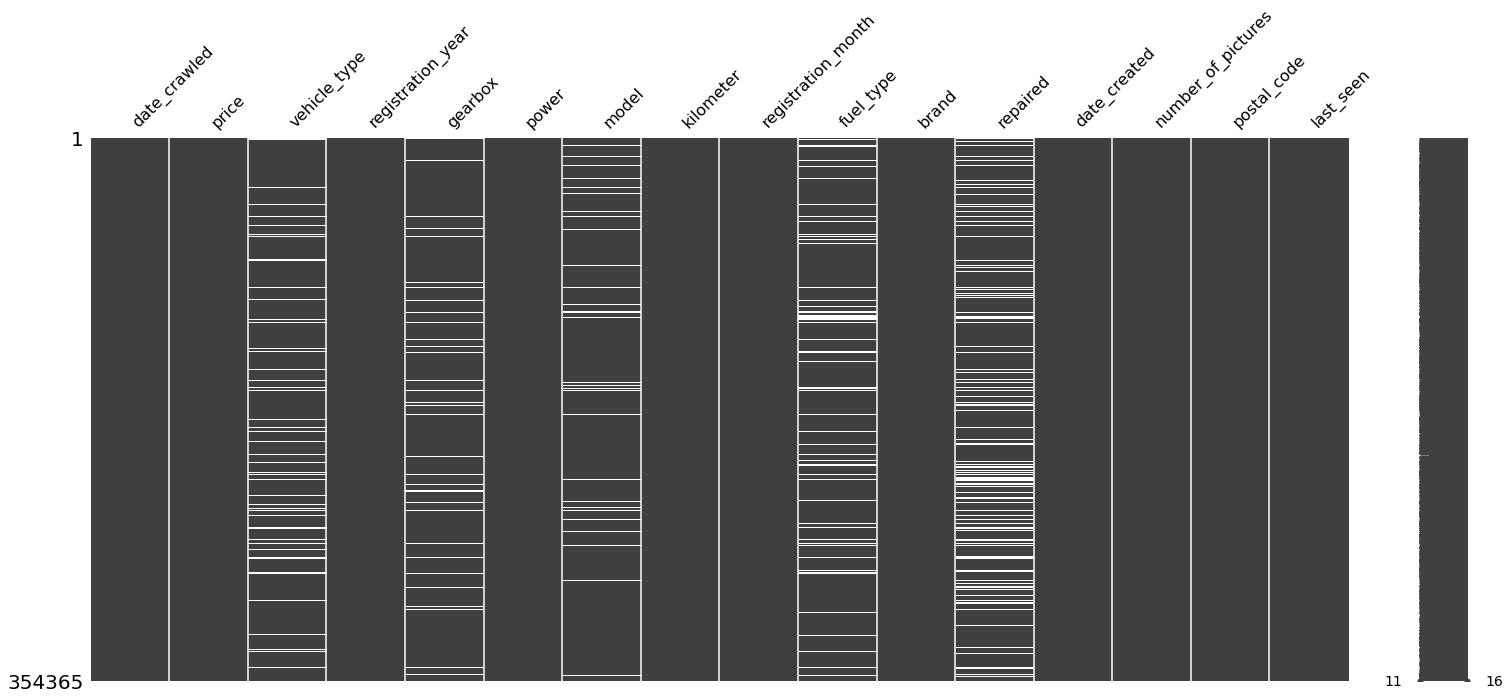

In [ ]:
msno.matrix(df);

В датасете есть 5 категориальных признаков, содержащих пропущенные значения, в дальнейшем обработаем их в пайплайне

### Обработка аномальных значений

In [ ]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


На основе описательной статистики можно выявить следущие проблемы:  
- в датасете есть наблюдения с нулевой ценой;  
- мощность некоторых автомобилей достигает 20 000 л.с., при этом встречаются наблюдения и с мощностью 0 л.с.;  
- среди объявлений есть машины, зарегистрированные в 1000 или 9999 году;  
- для некоторых автомобилей указан нулевой месяц регистрации;  
- признак `количество фотографий автомобиля`, вероятно, полностью состоит из нулей

Для удобства дальнейшей работы определим функции для визуализации количественных и категориальных признаков.

In [ ]:
# Визуализация категориальных признаков
def num_features_stats(feature, feature_name, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title, fontsize=16)

    # Гистограмма
    sns.histplot(x=feature, kde=True, ax=ax[0])
    ax[0].set_title('Распределение данных')
    ax[0].set_xlabel(feature_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)

    # Диаграмма размаха
    sns.boxplot(x=feature, ax=ax[1])
    ax[1].set_title('Диаграмма размаха')
    ax[1].set_xlabel(feature_name)
    ax[1].grid(True)

    plt.show()

    print()
    print('Описательная статистика')
    print(feature.describe())

Оценим количество объявлений и продаже "бесплатных" автомобилей:

In [ ]:
print(f'Доля объявлений о продаже автомобилей с ценой 0 евро: {len(df[df["price"] == 0]) / len(df):.2%}')

Доля объявлений о продаже автомобилей с ценой 0 евро: 3.04%


Сохраним исходный датасет, удалим наблюдения с нулевой ценой и визуализируем полученное распределние

In [ ]:
df_old = df.copy()

df = df[df['price'] != 0]

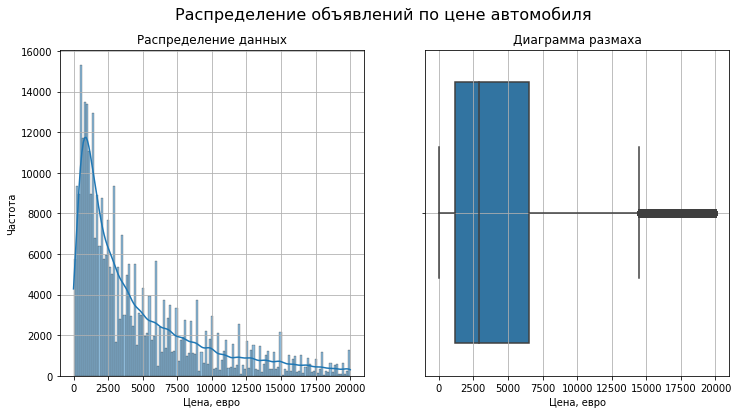


Описательная статистика
count    343593.000000
mean       4555.147363
std        4515.076200
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


In [ ]:
num_features_stats(df['price'],
                   'Цена, евро',
                   'Распределение объявлений по цене автомобиля')

По-прежнему встречаются наблюдения с нереалистично низкими значениями цены (например, 1 евро). Определим верхнюю границу стоимости одного процента самых дешёвых автомобилей:

In [ ]:
np.percentile(df['price'], 1)

100.0

Исключим из рассмотрения эти объявления

In [ ]:
df = df.query('price > 100')

Теперь посмотрим на мощность представленных автомобилей

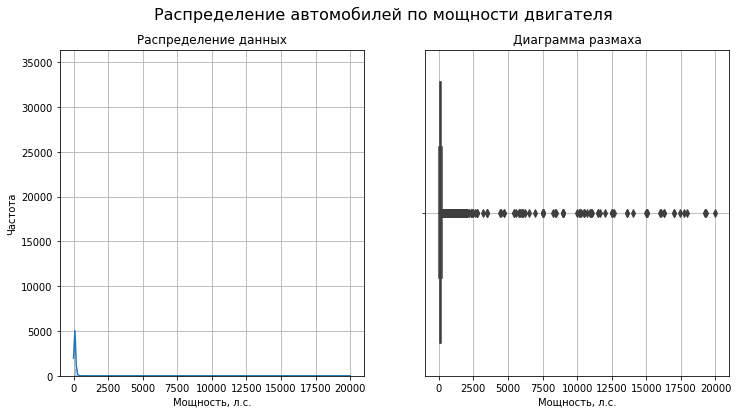


Описательная статистика
count    340020.000000
mean        111.584927
std         188.497445
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


In [ ]:
num_features_stats(df['power'],
                   'Мощность, л.с.',
                   'Распределение автомобилей по мощности двигателя')

In [ ]:
print(f'Доля автомобилей, у которых указана нулевая мощность двигателя: {len(df[df["power"] == 0]) / len(df):.2%}')
print(f'Доля автомобилей, у которых указана мощность двигателя < 20 л.с.: {len(df[(df["power"] != 0) & (df["power"] < 20)])  / len(df):.2%}')
print(f'Доля автомобилей, у которых указана мощность двигателя > 1000 л.с.: {len(df[df["power"] > 1000]) / len(df):.2%}')

Доля автомобилей, у которых указана нулевая мощность двигателя: 10.19%
Доля автомобилей, у которых указана мощность двигателя < 20 л.с.: 0.12%
Доля автомобилей, у которых указана мощность двигателя > 1000 л.с.: 0.08%


Чтобы не удалять более 10% наблюдений, заменим значения для строк с нулевой или аномально высокой мощностью на медианную

In [ ]:
RANDOM_STATE=42

train_df, test_df = train_test_split(df, random_state=RANDOM_STATE)
power_median = train_df['power'].median()

train_df.loc[(train_df['power'] < 20) | (train_df['power'] > 1000), 'power'] = power_median
test_df.loc[(test_df['power'] < 20) | (test_df['power'] > 1000), 'power'] = power_median

df = pd.concat([train_df, test_df], ignore_index=True)

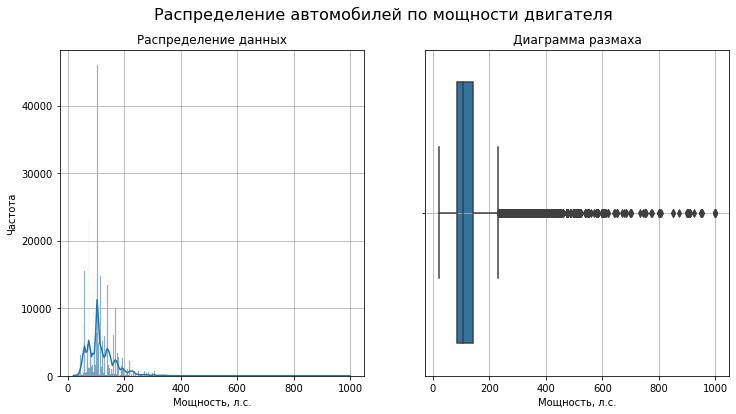


Описательная статистика
count    340020.000000
mean        119.028075
std          51.910579
min          20.000000
25%          84.000000
50%         105.000000
75%         143.000000
max        1000.000000
Name: power, dtype: float64


In [ ]:
num_features_stats(df['power'],
                   'Мощность, л.с.',
                   'Распределение автомобилей по мощности двигателя')

Распределение смещено влево и по-прежнему имеет большое количество выбросов, однако эти значения уже сложно назвать аномальными, поэтому пока не будем их корректировать.  

Перейдём к году регистрации автомобиля: посмотрим на распределения объявлений об автомобилях, зарегистрированных с 1900 по 2020

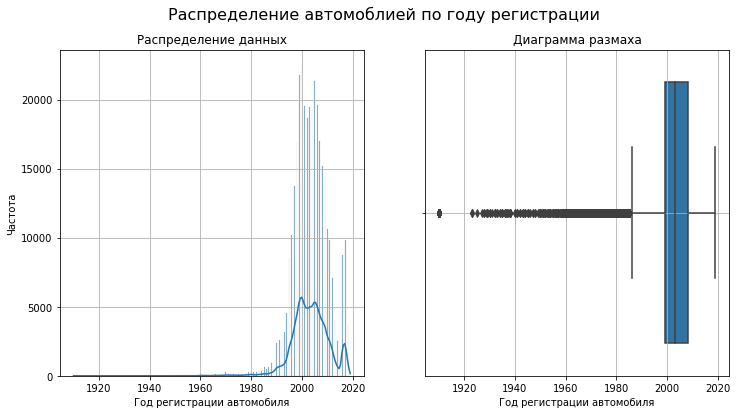


Описательная статистика
count    339909.000000
mean       2003.223883
std           7.305249
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64


In [ ]:
num_features_stats(df.query('(registration_year > 1900) and (registration_year < 2020)')['registration_year'],
                   'Год регистрации автомобиля',
                   'Распределение автомоблией по году регистрации')

Определим самую позднюю дату создания анкеты и дату скачивания анкеты из базы

In [ ]:
print(f'Максимальная дата скачивания анкеты из базы: {df["date_crawled"].max()}')
print(f'Максимальная дата создания анкеты: {df["date_created"].max()}')
print()
print(f'Доля автомобилей зарегистрованных до 1960 г.: {len(df[df["registration_year"] < 1960])/ len(df):.2%}')
print(f'Доля автомобилей зарегистрованных после 2016 г.: {len(df[df["registration_year"] > 2016]) / len(df):.2%}')

Максимальная дата скачивания анкеты из базы: 2016-04-07 14:36:58
Максимальная дата создания анкеты: 2016-04-07 00:00:00

Доля автомобилей зарегистрованных до 1960 г.: 0.09%
Доля автомобилей зарегистрованных после 2016 г.: 4.02%


Автомобиль не мог быть зарегистрован позже создания анкеты, поэтому исключим из рассмотрения автомобили с годом регистрации больше 2016. Также, исключим машины, зарегистрированные до 1960 г.

In [ ]:
df = df.query('1960 <= registration_year <= 2016')

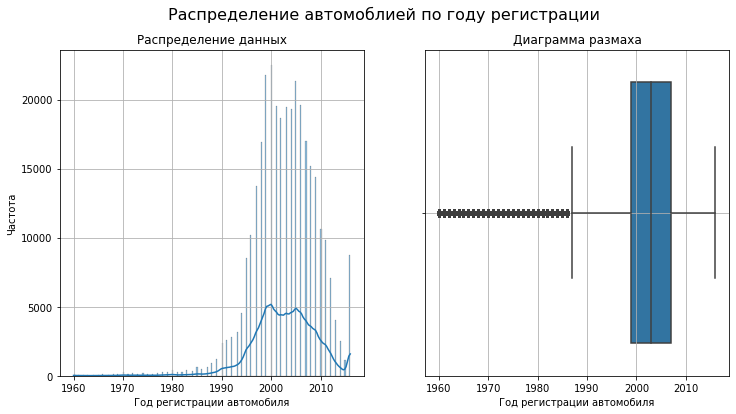


Описательная статистика
count    326050.000000
mean       2002.683858
std           6.645890
min        1960.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64


In [ ]:
num_features_stats(df['registration_year'],
                   'Год регистрации автомобиля',
                   'Распределение автомоблией по году регистрации')

### Удаление неинформативных признаков

Признаки `date_crawled`, `date_created`, `last_seen` и `number_of_pictures` неинформативны, поскольку дата создания или скачивания анкеты, а также дата последней активности пользователя не оказывают влияния на цену автомобиля, а `number_of_pictures` состоит из нулевых значений. Удалим эти признаки:

In [ ]:
df = df.drop(columns=['number_of_pictures', 'date_crawled', 'date_created', 'last_seen'])

Проведём корреляционный анализ:

In [ ]:
phik_matrix(df.fillna('unknown'), interval_cols=['price',
                                                 'registration_year',
                                                 'power',
                                                 'kilometer',
                                                 'registration_month',
                                                 'postal_code']).style.background_gradient(cmap ='coolwarm')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
price,1.000000,0.281916,0.654174,0.300184,0.480051,0.573573,0.309407,0.152402,0.122131,0.363523,0.350971,0.091680
vehicle_type,0.281916,1.000000,0.291182,0.503711,0.361917,0.897655,0.258503,0.183361,0.297401,0.587211,0.412119,0.067185
registration_year,0.654174,0.291182,1.000000,0.141781,0.231312,0.619938,0.384975,0.125533,0.109855,0.381730,0.211096,0.072178
gearbox,0.300184,0.503711,0.141781,1.000000,0.442055,0.624627,0.151965,0.218429,0.273135,0.513979,0.430890,0.087420
power,0.480051,0.361917,0.231312,0.442055,1.000000,0.675051,0.072455,0.091442,0.103717,0.495467,0.162508,0.084928
model,0.573573,0.897655,0.619938,0.624627,0.675051,1.000000,0.440737,0.181812,0.390737,0.997862,0.301079,0.213369
kilometer,0.309407,0.258503,0.384975,0.151965,0.072455,0.440737,1.000000,0.076163,0.097064,0.282415,0.248258,0.041870
registration_month,0.152402,0.183361,0.125533,0.218429,0.091442,0.181812,0.076163,1.000000,0.178031,0.092155,0.269930,0.045571
fuel_type,0.122131,0.297401,0.109855,0.273135,0.103717,0.390737,0.097064,0.178031,1.000000,0.241206,0.232257,0.050685
brand,0.363523,0.587211,0.381730,0.513979,0.495467,0.997862,0.282415,0.092155,0.241206,1.000000,0.144993,0.178289


Наиболее тесная линейная связь наблюдается между ценой и годом регистрации автомобиля (0,65), моделью автомобиля (0,57) и мощностью двигателя (0,48), при этом наблюдается очень тесная зависимость между брэндом и моделью автомобиля (0,998), один из них необходимо удалить. Целесообразно исключить признак `brand`, поскольку коэффициент корреляциии между `price` и `model` (0,57) выше, чем между `price` и `brand` (0,36). Также, удалим признаки `postal_code` и `registration_month` поскольку для этих переменных связь с целевым признаком слабая.

In [ ]:
df = df.drop(columns=['postal_code', 'registration_month', 'brand'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 326050 entries, 0 to 340019
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              326050 non-null  int64  
 1   vehicle_type       307518 non-null  object 
 2   registration_year  326050 non-null  int64  
 3   gearbox            311738 non-null  object 
 4   power              326050 non-null  float64
 5   model              311123 non-null  object 
 6   kilometer          326050 non-null  int64  
 7   fuel_type          303323 non-null  object 
 8   repaired           268200 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 24.9+ MB


Выведем отношение количества наблюдений до подготовки данных к количеству наблюдений после обработки

In [ ]:
print(f'Доля сохранившихся наблюдений: {round(len(df) / len(df_old), 2)}')

Доля сохранившихся наблюдений: 0.92


### Промежуточные выводы

В ходе подготовки данных были приведены к нижнему регистру названия признаков, обнаружены и обработаны явные дубликаты, устранены аномальные значения (удалены или заменены на медианные значения), исключены неинформативые признаки и устранена мультиколлинеарность. Также, были выявлены пропущенные значения, далее обработаем их в пайплайне.

## Обучение моделей

### Подготовка данных к обучению

Разделим данные на обучающую и тестовую выборки

In [ ]:
X = df.drop(columns='price')
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE
)

Сформуруем списки с количественными признаками для масштабирования и категориальными для кодирования. Так как среди признаков нет упорядоченных, применим OneHotEncoder, предварительно заполнив пропуски наиболее часто встречающимися значениями.

In [ ]:
ohe_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
num_cols = ['registration_year', 'power', 'kilometer']

In [ ]:
ohe_pipe = Pipeline(
    [
        (
            'simple_imputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
         ),

        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'
)

### Линейная регрессия

Обучим модель линейной регрессии, выведем время обучения и предсказания, а также качество модели на кросс-валидации и на тестовой выборке.

In [ ]:
lr = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [ ]:
start = time()

lr.fit(X_train, y_train)

end = time()
lr_fit_time = (end - start)

In [ ]:
scores = cross_val_score(
    lr,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error'
)

lr_cv_rmse = (-1) * sum(scores) / len(scores)
print('RMSE на кросс-валидации :', lr_cv_rmse)

RMSE на кросс-валидации : 2782.1108897925787


In [ ]:
start = time()

y_pred_lr = lr.predict(X_train) # Заменила X_test на X_train

end = time()
lr_pred_time = (end - start)

In [ ]:
print(f'Время обучения: {round(lr_fit_time, 2)} s.')
print(f'Время предсказания: {round(lr_pred_time, 2)} s.')

Время обучения: 21.86 s.
Время предсказания: 1.46 s.


- Время: обучение составило 21.86 секунд, а предсказание 1.46 секунды.  
- Качество: на обучающей выборке модель не достигает необходимого уровня качества, RMSE = 2782.11 при необходимом уровне: RMSE < 2500.

### LGBMRegressor

In [ ]:
lgbm = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LGBMRegressor(random_state=RANDOM_STATE))
])

In [ ]:
param_distribution = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 250, 500],
        'models__max_depth': range(2, 12, 2)
    }
]

Для обучения модели LGBMRegressor необходимо привести категориальные признаки к типу `category`

In [ ]:
X_train[ohe_cols] = X_train[ohe_cols].astype('category')
X_test[ohe_cols] = X_test[ohe_cols].astype('category')

Подберём оптимальные гиперпараметры:

In [ ]:
randomized_search_lgbm = RandomizedSearchCV(
    lgbm,
    param_distribution,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_lgbm.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simple_imputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'model',
                                                                                'fuel_type',
                                                                                'repaired']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['registration_year',
                                                                                'power',
                                                                                'kilometer'])])),
                                             ('models',
                                              LGBMRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [LGBMRegressor(random_state=42)],
                                         'models__max_depth': range(2, 12, 2),
                                         'models__n_estimators': [100, 250,
                                                                  500]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

Сохраним время обучения и время предсказания в отдельные переменные

In [ ]:
lgbm_res = pd.DataFrame(randomized_search_lgbm.cv_results_)
lgbm_fit_time = lgbm_res.loc[(lgbm_res['param_models__n_estimators'] == 500) &
       (lgbm_res['param_models__max_depth'] == 10), 'mean_fit_time'].values[0]
lgbm_pred_time = lgbm_res.loc[(lgbm_res['param_models__n_estimators'] == 500) &
       (lgbm_res['param_models__max_depth'] == 10), 'mean_score_time'].values[0]

Выведем время обучения полученной модели и её качество на обучающей выборке

In [ ]:
print(f'Время обучения: {round(lgbm_fit_time, 2)} с.')
print(f'Время предсказания: {round(lgbm_pred_time, 2)} с.')
print('RMSE на кросс-валидации', round((-1) * randomized_search_lgbm.best_score_, 2))

Время обучения: 15.11 с.
Время предсказания: 1.95 с.
RMSE на кросс-валидации 1674.9


- Время: обучение составило 15.11 секунды, а предсказание 1.95 секунды.  
- Качество: достигнут необходимый уровень качества модели, RMSE = 1674.9 (RMSE < 2500)

### CatBoostRegressor

In [ ]:
X_train[ohe_cols] = X_train[ohe_cols].astype('object')
X_test[ohe_cols] = X_test[ohe_cols].astype('object')

Так как CatBoost может работать с немасштабированными количественными признаками и категориальными характеристиками, можем обучить модель, не используя пайплайн, но предварительно заполним пропуски:

In [ ]:
imputer = SimpleImputer(strategy='most_frequent')
X_train[ohe_cols] = imputer.fit_transform(X_train[ohe_cols])
X_test[ohe_cols] = imputer.fit_transform(X_test[ohe_cols])

Инициализируем модель

In [ ]:
cb = CatBoostRegressor(cat_features=ohe_cols, random_state=RANDOM_STATE, verbose=False)

In [ ]:
param_grid_cb = {
    'depth': [4, 8],
    'iterations': [250, 500]
}

Подбираем оптимальную модель

In [ ]:
grid_search = GridSearchCV(cb,
                           param_grid=param_grid_cb,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           cv=5,
                           verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7ff1c46cfc40>,
             n_jobs=-1, param_grid={'depth': [4, 8], 'iterations': [250, 500]},
             scoring='neg_root_mean_squared_error')

In [ ]:
grid_search.best_params_

{'depth': 8, 'iterations': 500}

In [ ]:
cb_res = pd.DataFrame(grid_search.cv_results_)
cb_fit_time = cb_res.loc[(cb_res['param_depth'] == 8) &
           (cb_res['param_iterations'] == 500), 'mean_fit_time'].values[0]
cb_pred_time = cb_res.loc[(cb_res['param_depth'] == 8) &
           (cb_res['param_iterations'] == 500), 'mean_score_time'].values[0]

In [ ]:
print(f'Время обучения: {round(cb_fit_time, 2)} с.')
print(f'Время предсказания: {round(cb_pred_time, 2)}')
print('RMSE на тренировочной выборке', round((-1) * grid_search.best_score_, 2))

Время обучения: 73.74 с.
Время предсказания: 0.27
RMSE на тренировочной выборке 1684.12


- Время: обучение заняло 1 минуту 13.74 секунд, предсказание 0.27 секунд.  
- Качество: на кросс-валидации был достигнут необходимый уровень качества модели RMSE = 1684.12

## Анализ моделей

In [ ]:
res = {
    'model': ['LinearRegression', 'LGBMRegressor', 'CatBoostRegressor'],
    'fit_time': [lr_fit_time, lgbm_fit_time, cb_fit_time],
    'predict_time': [lr_pred_time, lgbm_pred_time, cb_pred_time],
    'RMSE_train_cv': [lr_cv_rmse,
                      (-1) * randomized_search_lgbm.best_score_,
                      (-1) * grid_search.best_score_]
}

res_df = pd.DataFrame(res)

In [ ]:
res_df

,model,fit_time,predict_time,RMSE_train_cv
0,LinearRegression,21.864102,1.455838,2782.110890
1,LGBMRegressor,15.114669,1.949385,1674.896075
2,CatBoostRegressor,73.736496,0.270512,1684.124335


- Модель линейной регрессии показала недостаточный уровень точности прогноза (метрика RMSE = 2782.11 при критерии RMSE < 2500),   также, по скорости обучения она уступает LGBM.    
- Качество прогноза CatBoost существенно лучше и удовлетворяет критерию (RMSE = 1684.12) Эта модель отличается и самым коротким   временем предсказания (0.27 с.), однако CatBoostRegressor обладает самым продолжительным временем обучения (1 мин. 13.74 с.)  
- Лучшее качество (RMSE = 1674.9) и самое быстрое обучение (15.11 с.) показала модель LightGBM, она является оптимальной по       рассматриваемым критериям. Проверим её качество на тестовой выборке:

In [ ]:
print('RMSE модели LightGBM на тестовой выборке:',
      round(root_mean_squared_error(y_test,
                                    randomized_search_lgbm.best_estimator_.predict(X_test)), 2))

RMSE модели LightGBM на тестовой выборке: 1668.2


Модель LightGBM показала высокое качество прогноза и на тестовой выборке.

# Вывод

**Целью исследования** являлось построение модели для определения стоимости автомобиля по данным о комплектации и технических характеристиках.  

В качестве **критериев качества модели** выступали:  
- качество предсказания;
- скорость предсказания;
- время обучения.

В ходе предобработки данных были выполнены следующие шаги:  
- обнаружены и устранены явные и скрытые дубликаты,  
- выявлены признаки, содержащие пропущенные значения,  
- обработаны аномальные значения,  
- проведён корреляционный анализ,
- исключены неинформативные признаки,  
- устранена мультиколлинеарность входных признаков.

На этапе подготовки данных к обучению моделей в пайплайне были:  
- заполнены пропуски наиболее встречающимися значениями,  
- закодированы категориальные признаки,  
- масштабированы количественные.

Были обучены модели линейной регрессии, LightGBM и CatBoost, подобраны оптимальные параметры, проведена проверка их качесва на кросс-валидации, а также зафиксировано время обучения и скорость предсказания.  
- Линейная регрессия показала низкую точность (RMSE = 2782.11) прогноза, а также уступила по скорости обучения (21.86 с.).  
- Прогноз CatBoost достиг высокого качества на обучающей выборке (1684.12), однако обучение модели шло более чем в три раза дольше (1 мин. 13 с.), чем у других алгоритмов.  
- Лучшую точность показала модель LightGBM (RMSE = 1674.9), помимо этого - LGBM обучается быстрее остальных (15.11 с.), на тестовой выборке модель также продемонстрировала высокое качество предсказания - RMSE = 1668.2.  

В результате проведённого исследования в качестве оптимальной модели была выбрана LGBMRegressor(max_depth=10, n_estimators=500, random_state=42).